In [1]:
import numpy as np
import imageio
import glob
import random
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from collections import OrderedDict
import copy
import elkai
from functools import partial
import time
import random

In [15]:
def load_sections(img_path, sample_number=None, ifrand=False):
    sections = []
    if not sample_number == None:
        img = np.asarray(imageio.imread(glob.glob(img_path+str(sample_number)+'.png')[0]))/255
        img = img.astype(np.uint8)
        sections.append(img.reshape(img.shape+(1,)))
    else:
        for path in glob.glob(img_path+'*.png'):
            img = np.asarray(imageio.imread(path))/255
            img = img.astype(np.uint8)
            sections.append(img.reshape(img.shape+(1,)))
        if ifrand:
            random.shuffle(sections)
    return sections

def plot_image(section, path = None, cmap_name = 'Greys', cv_map = None):
    matplotlib.rcParams['figure.dpi'] = 100
    x=np.arange(0,33)
    y=np.arange(0,33)
    X,Y=np.meshgrid(x,y)
    Z=section
    fig,ax = plt.subplots()
    cmap = plt.get_cmap(cmap_name)
    if cv_map is None:
        levels = MaxNLocator(nbins=100).tick_values(Z.min(),Z.max())
    else:
        levels = MaxNLocator(nbins=100).tick_values(cv_map[0],cv_map[1])
    norm = BoundaryNorm(levels, ncolors=cmap.N)
    ax.pcolormesh(X-0.5, Y-0.5, Z,shading='auto',cmap=cmap, norm=norm)
    ax.set_aspect('equal', 'box')
    if path is not None:
        for i in range(len(path)):
            ax.plot(path[i][0],path[i][1],color = 'r')
            for j in range(int(len(path[i][0])/2)):
                if (path[i][0][2*j+1]-path[i][0][2*j]) != 0 or (path[i][1][2*j+1]-path[i][1][2*j]) != 0:
                    ax.quiver(path[i][0][2*j],path[i][1][2*j],(path[i][0][2*j+1]-path[i][0][2*j])/2,(path[i][1][2*j+1]-path[i][1][2*j])/2)
                    break
    plt.show()

def divide_image(section, show = False):
    point_dic = {} # point_dic[(i,j)] = m (i,j) means the position and m means the certain area
    area_set = {} # area_set[m] = [(i.j),(p,q),...] m means the certain area and items are point position list
    same_set = {} # same_set[m] = n means m and n areas are connected
    count = 0
    for i in range(32):
        for j in range(32):
            if section[i,j] == 1:
                if (i == 0) | (j == 0):
                    point_dic[(i,j)] = count
                    count += 1
                if (i == 0) & (j > 0):
                    if section[i,j - 1] == 1:
                        point_dic[(i,j)] = point_dic[(i,j-1)]
                    else:
                        point_dic[(i,j)] = count
                        count += 1
                if (i > 0) & (j == 0) :
                    if section[i-1,j] == 1:
                        point_dic[(i,j)] = point_dic[(i-1,j)]
                    else:
                        point_dic[(i,j)] = count
                        count += 1
                if (i > 0) & (j > 0):
                    if section[i,j - 1] == 1:
                        point_dic[(i,j)] = point_dic[(i,j-1)]
                    if section[i-1,j] == 1:
                        if (i,j) in point_dic:
                            if (point_dic[(i,j)] != point_dic[(i-1,j)]):
                                
                                if point_dic[(i,j)] not in same_set:
                                    same_set[point_dic[(i,j)]] = [point_dic[(i-1,j)]]
                                elif point_dic[(i-1,j)] not in same_set[point_dic[(i,j)]]:
                                    same_set[point_dic[(i,j)]].append(point_dic[(i-1,j)])
                                if point_dic[(i-1,j)] not in same_set:
                                    same_set[point_dic[(i-1,j)]] = [point_dic[(i,j)]]
                                elif point_dic[(i,j)] not in same_set[point_dic[(i-1,j)]]:
                                    same_set[point_dic[(i-1,j)]].append(point_dic[(i,j)])
                                if (point_dic[(i-1,j)] < point_dic[(i,j)]):
                                    point_dic[(i,j)] = point_dic[(i-1,j)]
                        else:
                            point_dic[(i,j)] = point_dic[(i-1,j)]
                    if (i,j) not in point_dic:
                        point_dic[(i,j)] = count
                        count += 1
                if point_dic[(i,j)] in area_set:
                    area_set[point_dic[(i,j)]].append([i,j])
                else:
                    area_set[point_dic[(i,j)]] = [[i,j]]
                                   
    stack = []
    tstack = []
    while same_set != {}:
        tstack.append(list(same_set.keys())[0])
        ttstack = []
        while tstack != []:
            tkey = tstack.pop(0)
            if tkey in same_set:
                ttstack.append(tkey)
                tstack.extend(same_set[tkey])
                same_set.pop(tkey)
        stack.append(ttstack)
          
    for i in range(len(stack)):
        t = stack[i]
        tc = min(t)
        for j in range(len(t)):
            if t[j] != tc:
                area_set[tc].extend(area_set[t[j]])
                area_set.pop(t[j])

    # final area_set
    
    set_key = list(area_set.keys())     
    if show:
        divided_section = np.zeros(shape = (32,32))
        for i in range(len(area_set)):
            for j in range(len(area_set[set_key[i]])):
                divided_section[area_set[set_key[i]][j][0],area_set[set_key[i]][j][1]] = i+1
        plot_image(divided_section, cmap_name='PiYG')

    return list(area_set.values())

def line_range(section):
    range_set = []
    for i in range(section.shape[0]):
        start = None
        final = None
        for j in range(section.shape[1]):
            if section[i,j] == 1:
                if start == None:
                    start = j
                final = j
        if start !=None:
            range_set.append([i,start,final])
    return range_set

def zig_zag_path(LR,flag = 1):
    path_x = []
    path_y = []
    for i in range(len(LR)):
        if flag == 1:
            path_x.extend([LR[i][1],LR[i][2]])
            path_y.extend([LR[i][0],LR[i][0]])
        else:
            path_x.extend([LR[i][2],LR[i][1]])
            path_y.extend([LR[i][0],LR[i][0]])
        flag = -flag
    return [path_x, path_y]

def zig_zag_from_points(area_points,flag = 1):
    # area_points point position list.
    # flag = 1 right 2 left 3 up 4 down 
    if flag == 1 or flag == 2:
        dic = {}
        for j in range(len(area_points)):
            if area_points[j][0] in dic:
                dic[area_points[j][0]].append(area_points[j][1])
            else:
                dic[area_points[j][0]] = [area_points[j][1]]
        sorted_keys = list(dic.keys())
        sorted_keys.sort()
        # dic keys are row coordinates item are col coordinates
        Bound = []
        for j in range(len(sorted_keys)):
            Bound.append([[sorted_keys[j],min(dic[sorted_keys[j]])],[sorted_keys[j],max(dic[sorted_keys[j]])]])
    elif flag == 3 or flag == 4:
        dic = {}
        for j in range(len(area_points)):
            if area_points[j][1] in dic:
                dic[area_points[j][1]].append(area_points[j][0])
            else:
                dic[area_points[j][1]] = [area_points[j][0]]
        sorted_keys = list(dic.keys())
        sorted_keys.sort()
        # dic keys are col coordinates item are row coordinates
        Bound = []
        for j in range(len(sorted_keys)):
            Bound.append([[min(dic[sorted_keys[j]]),sorted_keys[j]],[max(dic[sorted_keys[j]]),sorted_keys[j]]])
    elif flag == 5 or flag == 6:
        dic = {}
        for j in range(len(area_points)):
            if area_points[j][0] in dic:
                dic[area_points[j][0]].append(area_points[j][1])
            else:
                dic[area_points[j][0]] = [area_points[j][1]]
        sorted_keys = list(dic.keys())
        sorted_keys.sort(reverse=True)
        # dic keys are row coordinates item are col coordinates
        Bound = []
        for j in range(len(sorted_keys)):
            Bound.append([[sorted_keys[j],min(dic[sorted_keys[j]])],[sorted_keys[j],max(dic[sorted_keys[j]])]])
    elif flag == 7 or flag == 8:
        dic = {}
        for j in range(len(area_points)):
            if area_points[j][1] in dic:
                dic[area_points[j][1]].append(area_points[j][0])
            else:
                dic[area_points[j][1]] = [area_points[j][0]]
        sorted_keys = list(dic.keys())
        sorted_keys.sort(reverse=True)
        # dic keys are col coordinates item are row coordinates
        Bound = []
        for j in range(len(sorted_keys)):
            Bound.append([[min(dic[sorted_keys[j]]),sorted_keys[j]],[max(dic[sorted_keys[j]]),sorted_keys[j]]])
    else:
        print('flag should be 1,2,3 or 4.')
        return

    return path_from_bound(Bound, flag = flag%2)

def path_from_bound(Bound, flag = 1):
    L = 0
    path_x = [] 
    path_y = [] 
    if flag == 1:
        path_y.append(Bound[0][0][0])
        path_y.append(Bound[0][1][0])
        path_x.append(Bound[0][0][1])
        path_x.append(Bound[0][1][1])
    else:
        path_y.append(Bound[0][1][0])
        path_y.append(Bound[0][0][0])
        path_x.append(Bound[0][1][1])
        path_x.append(Bound[0][0][1]) 
    L += ((path_x[-1]-path_x[-2])**2+(path_y[-1]-path_y[-2])**2)**0.5
    
    for i in range(len(Bound)-1):
        p1 = Bound[i+1][0]
        p2 = Bound[i+1][1]
        L += ((p2[0]-p1[0])**2+(p2[1]-p1[1])**2)**0.5
        l1 = ((path_y[-1]-p1[0])**2+(path_x[-1]-p1[1])**2)**0.5
        l2 = ((path_y[-1]-p2[0])**2+(path_x[-1]-p2[1])**2)**0.5
        if l1 < l2:
            path_y.extend([p1[0],p2[0]])
            path_x.extend([p1[1],p2[1]])
            L += l1
        else:
            path_y.extend([p2[0],p1[0]])
            path_x.extend([p2[1],p1[1]])
            L += l2
    sf = [[path_x[0],path_y[0]],[path_x[-1],path_y[-1]]]
    return ([path_x,path_y],L,sf)


def MGD_Path(section, n_all_pos = 7, show = False, print_time = False, print_log = False, iteration_loop = 500, position_rate = 0.3, change_rate = 0.7):
    (area_set, LR_set, path_set, path_l_set, path_sf_set) = divide_image(section, show = show, res = 2)
    TL = np.sum(path_l_set)
    T_path = []
    T_path = copy.deepcopy(path_set[0])
    for i in range(len(path_sf_set)-1):
        TL += ((path_sf_set[i+1][0][0]-path_sf_set[i][1][0])**2+(path_sf_set[i+1][0][1]-path_sf_set[i][1][1])**2)**0.5
        T_path[0].extend(path_set[i+1][0])
        T_path[1].extend(path_set[i+1][1])


    if show:
        (TL_tsp, path, T_path_tsp) = tsp_path(section, path_set, path_l_set, path_sf_set, show = show)

    TL_tsp_set = []
    path_sf_set_initial = copy.deepcopy(path_sf_set)
    if print_time:
        pt = time.time()
    a_set = []
    n_path_set = len(path_set)
    
    if n_path_set > n_all_pos:
        a = [0]*n_path_set
        current_a = copy.deepcopy(a)
        current_TL = 100000
        position_n = int(n_path_set*0.3)
        for i in range(iteration_loop):
            a = copy.deepcopy(current_a)
            path_sf_set = copy.deepcopy(path_sf_set_initial)
            if position_n < 1:
                position_n = 1
            pos = random.sample(range(0,n_path_set), position_n)
            for j in pos:
                if random.random() < change_rate:
                    if a[j] == 1:
                        a[j] = 0
                    else:
                        a[j] = 1
            for j in range(len(a)-2):
                if a[j] == 1:
                    path_sf_set[j].reverse()
            (TL_tsp, path, T_path_tsp) = tsp_path(section, path_set, path_l_set, path_sf_set, show = False)
            TL_tsp_set.append(TL_tsp)
            a_set.append(a)
            if TL_tsp < current_TL:
                if print_log:
                    print(i,a)
                current_TL = TL_tsp
                current_a = copy.deepcopy(a)
    else:
        current_a = [0]*n_path_set
        current_TL = 10000
        for i in range(2**n_path_set):
            path_sf_set = copy.deepcopy(path_sf_set_initial)
            a = bin(i)
            ta = [0]*n_path_set
            for j in range(len(a)-2):
                if a[-1-j] == '1':
                    ta[j] = 1
            for j in range(len(ta)):
                if ta[j] == 1:
                    path_sf_set[j].reverse()
            (TL_tsp, path, T_path_tsp) = tsp_path(section, path_set, path_l_set, path_sf_set, show = False)
            TL_tsp_set.append(TL_tsp)
            if TL_tsp < current_TL:
                current_a = copy.deepcopy(ta)
                current_TL = TL_tsp

   

    if print_time:
        print(time.time()-pt)
    
    return (current_a, current_TL)

class GA_path():
    def __init__(self, fun, initial_num, variable_size, crossover_rate = 0.8, mutation_rate = 0.01):
        self.fun = fun
        self.initial_num = initial_num
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.variable_size = variable_size
        self.population = []
        self.value_population = []
        p_tem = np.arange(variable_size[1])
        for i in range(self.initial_num):
            tp = []
            for j in range(variable_size[0]):
                tp.append(random.choice(p_tem))
            self.population.append(tp)
            self.value_population.append(self.fun(tp))
        
        
    def crossover(self):
        index = np.arange(len(self.population))
        random.shuffle(index)
        for i in range(int(len(self.population)/2)):
            if random.random() < self.crossover_rate:
                pos = random.randint(0,self.variable_size[0]-1)
                m = index[2*i]
                n = index[2*i+1]
                self.population.append(self.population[m][:pos] + self.population[n][pos:])
                self.population.append(self.population[n][:pos] + self.population[m][pos:])
                self.value_population.append(self.fun(self.population[-2]))
                self.value_population.append(self.fun(self.population[-1]))
    
    def mutation(self):
        for i in range(len(self.population)):
            sp = copy.deepcopy(self.population[i])
            flag = 0
            for j in range(self.variable_size[0]):
                if random.random() < self.mutation_rate:
                    sp[j] = random.choice(np.arange(self.variable_size[1]))
                    flag = 1
            if flag == 1:
                self.population.append(sp)
                self.value_population.append(self.fun(sp))
        
    def get_population(self):
        return self.population
    
    def select(self):
        value_array = np.asarray(self.value_population)
        value_array = np.exp(value_array - min(value_array))
        p = value_array/np.sum(value_array)
        index = np.random.choice(len(self.population), self.initial_num, replace=False, p=value_array/np.sum(value_array))
        max_value = np.max(self.value_population)
        max_pop = copy.deepcopy(self.population[self.value_population.index(max_value)])
        self.population = [self.population[i] for i in index]
        self.value_population = [self.value_population[i] for i in index]
        if np.max(self.value_population) < max_value:
            self.population.append(max_pop)
            self.value_population.append(max_value)
            min_index = self.value_population.index(np.min(self.value_population))
            self.population.pop(min_index)
            self.value_population.pop(min_index)
            
    def iteration(self, loop, end_loop = 20):
        max_value_his = []
        max_value = np.max(self.value_population)
        max_value_his.append(max_value)
        count = 0
        for _ in range(loop):
            self.crossover()
            self.mutation()
            self.select()
            if max_value == np.max(self.value_population):
                count += 1
            else:
                count = 0
            max_value = np.max(self.value_population)
            max_value_his.append(max_value)
            if count == end_loop:
                break
        max_pop = self.population[self.value_population.index(max_value)]
        return max_value, max_value_his, max_pop
    
    
def tsp_path(initial_point, path_sf_set):
    n_v = len(path_sf_set)
    M = np.zeros(shape = (n_v+1, n_v+1))

    for i in range(0,n_v+1):
        for j in range(0,n_v+1):
            if j != i:
                if i == 0:
                    M[i, j] = ((initial_point[0]-path_sf_set[j-1][0][0])**2+(initial_point[1]-path_sf_set[j-1][0][1])**2)**0.5
                else:
                    if j == 0:
                        M[i, j] = ((initial_point[0]-path_sf_set[i-1][1][0])**2+(initial_point[1]-path_sf_set[i-1][1][1])**2)**0.5
                    else:
                        M[i, j] = ((path_sf_set[i-1][1][0]-path_sf_set[j-1][0][0])**2+(path_sf_set[i-1][1][1]-path_sf_set[j-1][0][1])**2)**0.5
                    

    
    if M.shape[0]>2:
        Mint = np.around(M*100)
        path_order = elkai.solve_int_matrix(Mint) 
    else:
        path_order = np.arange(0,M.shape[0])
    
    TL_tsp = 0
    for i in range(len(path_order)-1):
        TL_tsp += M[path_order[i],path_order[i+1]]  
    
#     if show:
#         plot_image(section, [T_path_tsp],cv_map=[0,2])
    return (TL_tsp, path_order)

def ga_tsp_path(a, section, area_set, initial_point = None):
    path_set =[]
    path_l_set = []
    path_sf_set = []
    for i in range(len(a)):
        (path,L,sf) = zig_zag_from_points(area_set[i], flag = a[i]+1)
        path_set.append(path)
        path_l_set.append(L)
        path_sf_set.append(sf)
    
    if initial_point is None:
        initial_point = [random.randint(0,section.shape[0]), random.randint(0,section.shape[1])]
    (TL_tsp, _) = tsp_path(initial_point, path_sf_set)
    return -(TL_tsp+np.sum(path_l_set))




### The Objective

The aim of this research is to plan a path to fill all the grey pixels in 32x32 images. This file demonstrates the zig-zag path planning through improved coverage path planning algorithms. The procedure are shown as follows.
- Image segmentation. Based on connections between pixels, divide the pixels into groups. Then local path will be planned in each group.
- Path order planning. After all the local paths are planned, the order to pass all the local paths is planned.
- Path type planning. Local path in each group consists of several different types. For example, vertical lines can make up a local path, so does horizental lines. This kind of path type is planned based on the result from path order planning.

Following sections will show the algorithm with examples.

### Initial Zig-zag path

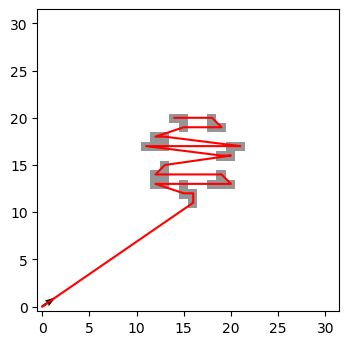

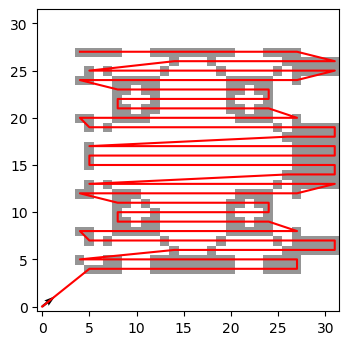

In [46]:
# Locad data set
sections = load_sections('Sections/Database_32x32_v2/')

# example 1
section = sections[1][:,:,0] # 1,180
# initial zig-zag path
LR = line_range(section)
path = zig_zag_path(LR,flag = 1)
path[0].insert(0,0)
path[1].insert(0,0)
plot_image(section, [path],cv_map=[0,2])

# example 2
section = sections[180][:,:,0] # 1,180
# initial zig-zag path
LR = line_range(section)
path = zig_zag_path(LR,flag = 1)
path[0].insert(0,0)
path[1].insert(0,0)
plot_image(section, [path],cv_map=[0,2])

max: 589.3244876531197 mean: 230.50226069991078


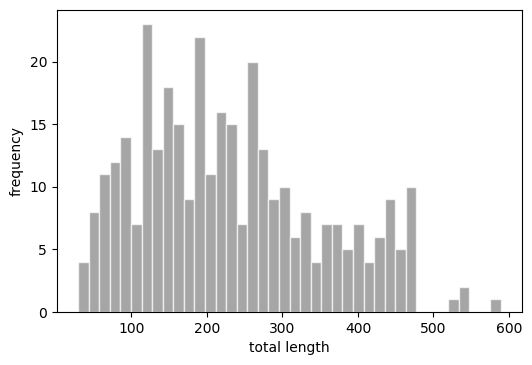

In [60]:
# Total path lengths of all the images in the dataset
PL_set0 = []
for i in range(len(sections)):
    section = sections[i][:,:,0] 
    LR = line_range(section)
    x,y = zig_zag_path(LR,flag = 1)
    x.insert(0,0)
    y.insert(0,0)
    L = 0
    for j in range(len(x)-1):
        L += np.linalg.norm(np.asarray([x[j+1]-x[j],y[j+1]-y[j]]))
    PL_set0.append(L)

print('max:',np.max(PL_set0),'mean:',np.mean(PL_set0))
plt.hist(PL_set0, bins=40, facecolor="grey", edgecolor="white", alpha=0.7)  
plt.xlabel('total length')
plt.ylabel('frequency')
plt.show()

### Image segmentation
From previous section, we can see a great part of initial zig-zag path are useless because they are passing through white pixels. So we can divide grey pixels into groups and plan the path in each group. We realize it through simple pixel connection algorithm which means connected pixels should be in the same group. Two pixels are connected if one is at the left, right, up and down of the other.

Two examples are shown below. We can see if we connect all the local paths, total path length will be less than initial one.

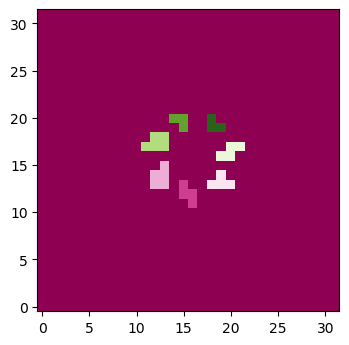

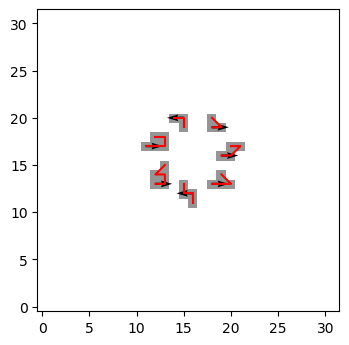

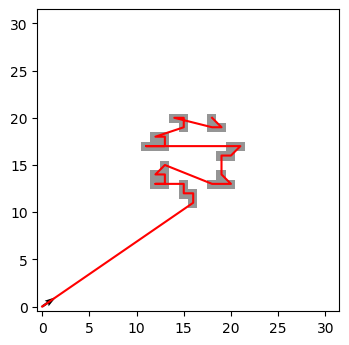

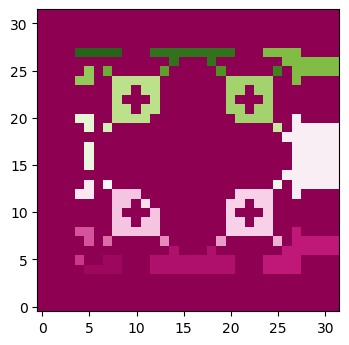

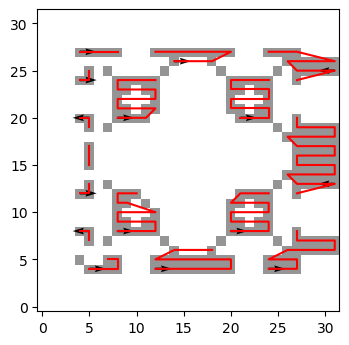

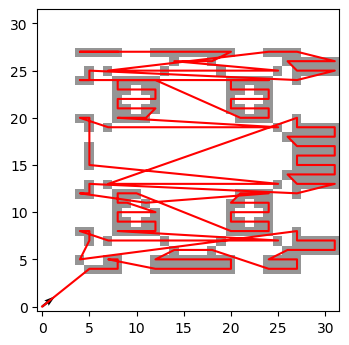

In [52]:
# example 1
section = sections[1][:,:,0]
area_set = divide_image(section,show = True)
path_set = []
for i in range(len(area_set)):
    area_set[i].sort()
    x = area_set[i][0][0]
    s = area_set[i][0][1]
    f = s
    LR = []
    for j in range(len(area_set[i])):
        p = area_set[i][j]
        if x != p[0]:
            LR.append([x,s,f])
            x = p[0]
            s = p[1]
            f = s
        else:
            if p[1]>f:
                f = p[1]
            elif p[1]<s:
                s = p[1]
    LR.append([x,s,f])
    path_set.append(zig_zag_path(LR,flag = 1))
x = [0]
y = [0]
for j in range(len(path_set)):
    x.extend(path_set[j][0])
    y.extend(path_set[j][1])
plot_image(section, path_set, cv_map=[0,2])
plot_image(section, [[x,y]], cv_map=[0,2])

# example 2
section = sections[180][:,:,0]
area_set = divide_image(section,show = True)
path_set = []
for i in range(len(area_set)):
    area_set[i].sort()
    x = area_set[i][0][0]
    s = area_set[i][0][1]
    f = s
    LR = []
    for j in range(len(area_set[i])):
        p = area_set[i][j]
        if x != p[0]:
            LR.append([x,s,f])
            x = p[0]
            s = p[1]
            f = s
        else:
            if p[1]>f:
                f = p[1]
            elif p[1]<s:
                s = p[1]
    LR.append([x,s,f])
    path_set.append(zig_zag_path(LR,flag = 1))
x = [0]
y = [0]
for j in range(len(path_set)):
    x.extend(path_set[j][0])
    y.extend(path_set[j][1])
plot_image(section, path_set, cv_map=[0,2])
plot_image(section, [[x,y]], cv_map=[0,2])

max: 641.8253277076757 mean: 225.3000889987355


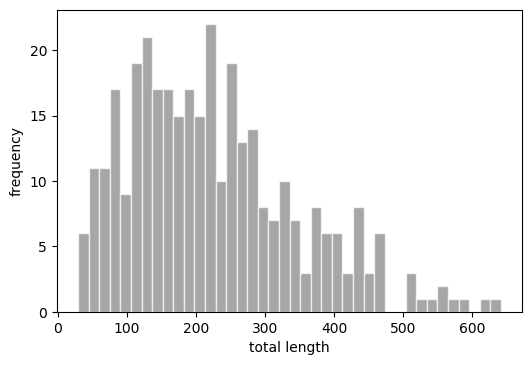

In [59]:
# Total path lengths of all the images in the dataset
PL_set1 = []
for i in range(len(sections)):
    section = sections[i][:,:,0]
    area_set = divide_image(section,show = False)
    path_set = []
    for j in range(len(area_set)):
        area_set[j].sort()
        x = area_set[j][0][0]
        s = area_set[j][0][1]
        f = s
        LR = []
        for k in range(len(area_set[j])):
            p = area_set[j][k]
            if x != p[0]:
                LR.append([x,s,f])
                x = p[0]
                s = p[1]
                f = s
            else:
                if p[1]>f:
                    f = p[1]
                elif p[1]<s:
                    s = p[1]
        LR.append([x,s,f])
        path_set.append(zig_zag_path(LR,flag = 1))
    x = [0]
    y = [0]
    for j in range(len(path_set)):
        x.extend(path_set[j][0])
        y.extend(path_set[j][1])
    L = 0
    for j in range(len(x)-1):
        L += np.linalg.norm(np.asarray([x[j+1]-x[j],y[j+1]-y[j]]))
    PL_set1.append(L)

print('max:',np.max(PL_set1),'mean:',np.mean(PL_set1))
plt.hist(PL_set1, bins=40, facecolor="grey", edgecolor="white", alpha=0.7)  
plt.xlabel('total length')
plt.ylabel('frequency')
plt.show()

### Path Order Planning
After all the local paths in groups are planned, we should plan the order to pass all the local paths to reduce the total length. It is **Traveling Salesman Problem (TSP)** Problem and we use **LKH** algorithm to solve it. Note that initial point (start point) is set as fixed, [0,0].  

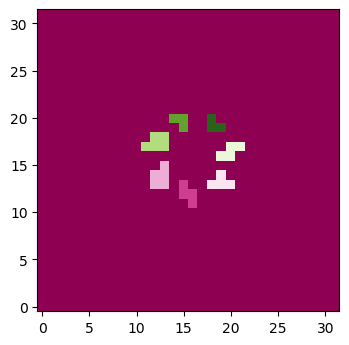

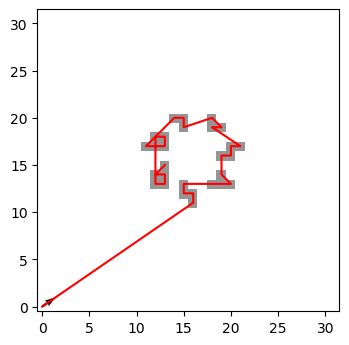

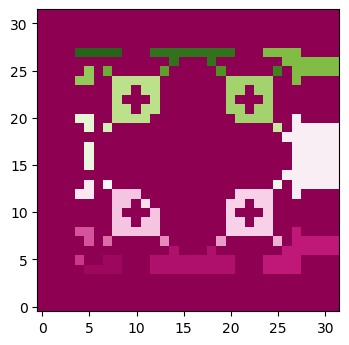

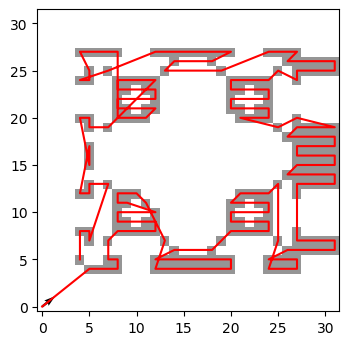

In [38]:
# example 1
initial_point = [0,0]
section = sections[1][:,:,0]

# image segmentation
area_set = divide_image(section,show = True)

# local path 
flag = 1
path_set = []
path_l_set = []
path_sf_set = []
for i in range(len(area_set)):
    (path,L,sf) = zig_zag_from_points(area_set[i], flag = flag)
    path_set.append(path)
    path_l_set.append(L)
    path_sf_set.append(sf)

# LKH
(TL_tsp, path_order) = tsp_path(initial_point, path_sf_set)

# plot 
T_path = [[],[]]
for i in path_order:
    if i == 0:
        T_path[0].extend([initial_point[0]])
        T_path[1].extend([initial_point[1]])
    else:
        T_path[0].extend(path_set[i-1][0])
        T_path[1].extend(path_set[i-1][1])
plot_image(section,[T_path],cv_map=[0,2])


# example 2
initial_point = [0,0]
section = sections[180][:,:,0]

# image segmentation
area_set = divide_image(section,show = True)

# local path 
flag = 1
path_set = []
path_l_set = []
path_sf_set = []
for i in range(len(area_set)):
    (path,L,sf) = zig_zag_from_points(area_set[i], flag = flag)
    path_set.append(path)
    path_l_set.append(L)
    path_sf_set.append(sf)

# LKH
(TL_tsp, path_order) = tsp_path(initial_point, path_sf_set)

# plot 
T_path = [[],[]]
for i in path_order:
    if i == 0:
        T_path[0].extend([initial_point[0]])
        T_path[1].extend([initial_point[1]])
    else:
        T_path[0].extend(path_set[i-1][0])
        T_path[1].extend(path_set[i-1][1])
plot_image(section,[T_path],cv_map=[0,2])

max: 641.8253277076757 mean: 217.5977696117423


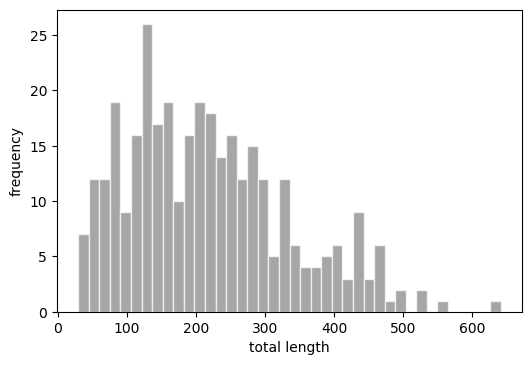

In [58]:
# Total path lengths of all the images in the dataset
PL_set2 = []
for i in range(len(sections)):
    initial_point = [0,0]
    section = sections[i][:,:,0]
    area_set = divide_image(section)
    flag = 1
    path_set = []
    path_l_set = []
    path_sf_set = []
    for i in range(len(area_set)):
        (path,L,sf) = zig_zag_from_points(area_set[i], flag = flag)
        path_set.append(path)
        path_l_set.append(L)
        path_sf_set.append(sf)
    (TL_tsp, path_order) = tsp_path(initial_point, path_sf_set)
    PL_set2.append(TL_tsp+np.sum(path_l_set))

print('max:',np.max(PL_set2),'mean:',np.mean(PL_set2))
plt.hist(PL_set2, bins=40, facecolor="grey", edgecolor="white", alpha=0.7)  
plt.xlabel('total length')
plt.ylabel('frequency')
plt.show()

### Path Type Planning
it is obvious that if we change path types of several local paths, we can get shorter total path. For example, replace vertical lines with horizental lines. We define 8 typical path type in this section and optimize them through genetic algorithm and LKH methods

#### 8 Typical Path Type

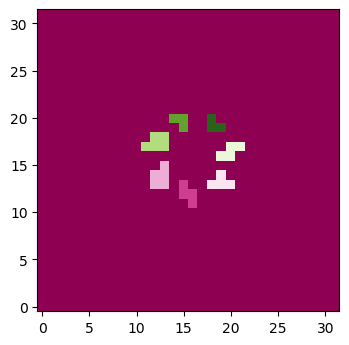

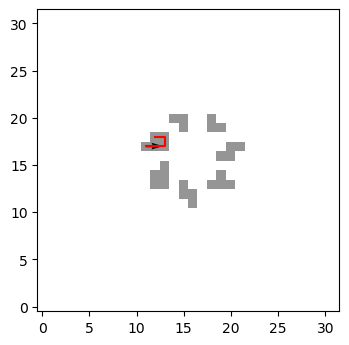

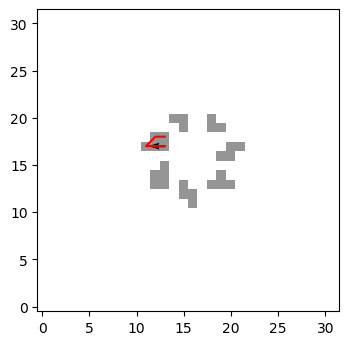

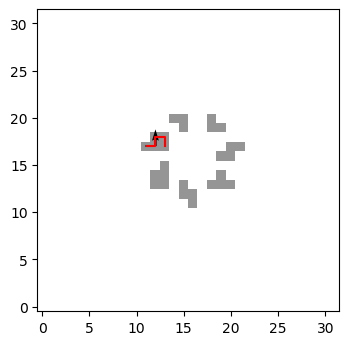

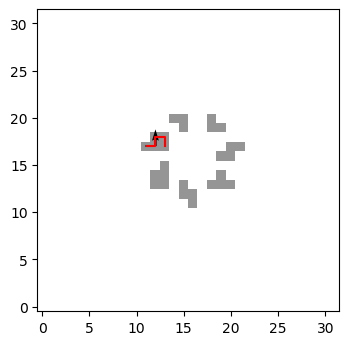

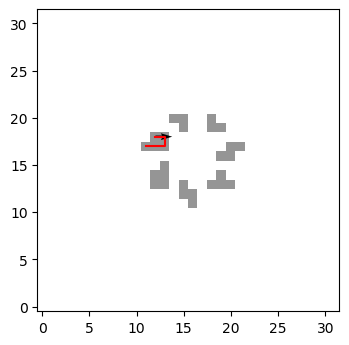

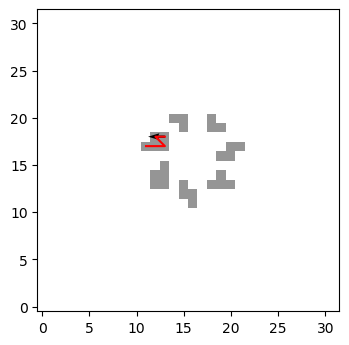

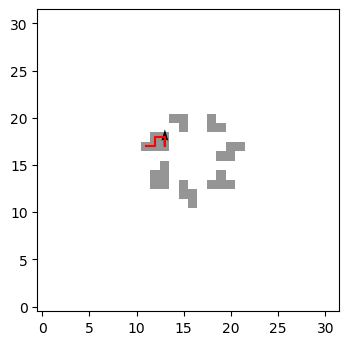

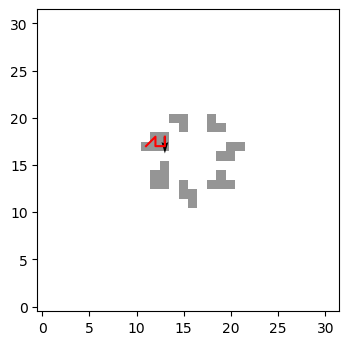

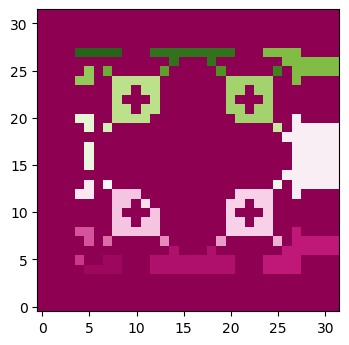

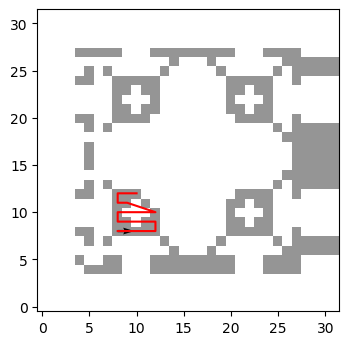

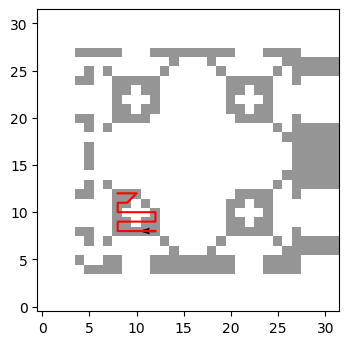

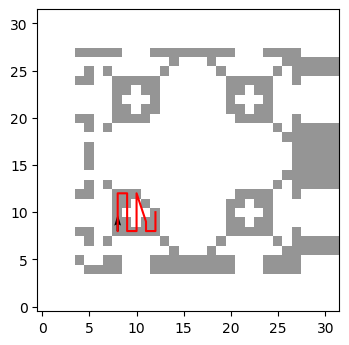

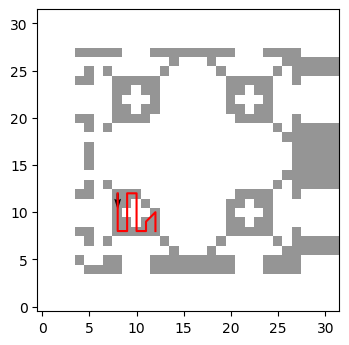

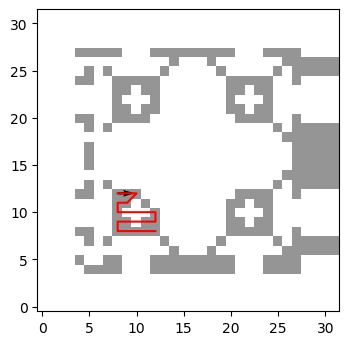

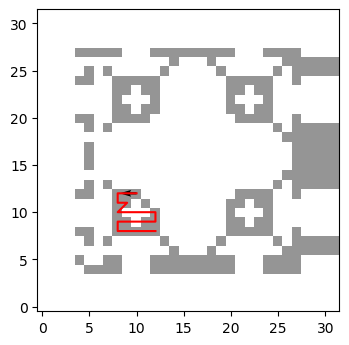

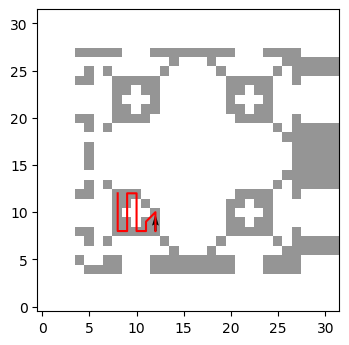

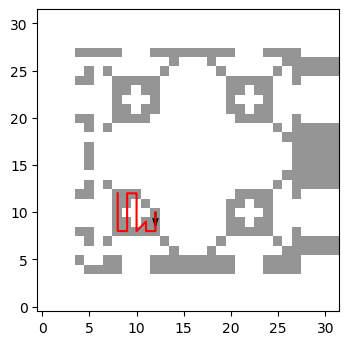

In [40]:
# example 1
section = sections[1][:,:,0]
area_set = divide_image(section,show = True)
flag = 1
i = 4
for j in range(8):
    (path,L,sf) = zig_zag_from_points(area_set[i], flag = j+1)
    plot_image(section,path = [path],cv_map=[0,2])

# example 2
section = sections[180][:,:,0]
area_set = divide_image(section,show = True)
flag = 1

i = 9
for j in range(8):
    (path,L,sf) = zig_zag_from_points(area_set[i], flag = j+1)
    plot_image(section,path = [path],cv_map=[0,2])

#### Example 1

time: 1.8750038146972656
path length: 54.98964658723397


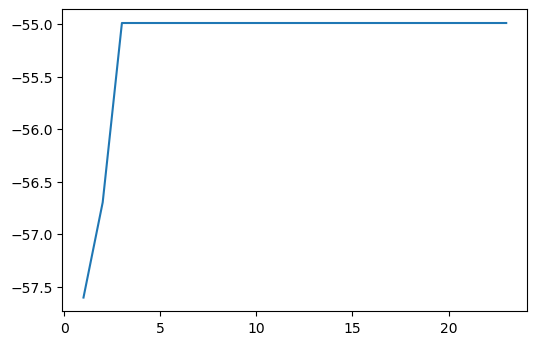

In [41]:
section = sections[1][:,:,0]

# path type planning
pt = time.time()
area_set = divide_image(section)
tf = partial(ga_tsp_path,section = section, area_set = area_set, initial_point = [0,0])
gaaa = GA_path(tf,50,[len(area_set),8],crossover_rate=0.9, mutation_rate = 0.1)
max_value, max_value_his, max_pop = gaaa.iteration(50)
print('time:',time.time()-pt)
fig,ax = plt.subplots()
ax.plot(np.arange(len(max_value_his))+1, max_value_his)
print('path length:',-max_value)

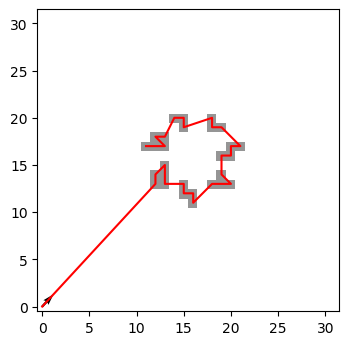

In [42]:
# plot
path_set = []
path_l_set = []
path_sf_set = []

for i in range(len(max_pop)):
    (path,L,sf) = zig_zag_from_points(area_set[i], flag = max_pop[i]+1)
    path_set.append(path)
    path_l_set.append(L)
    path_sf_set.append(sf)

(TL_tsp, path_order) = tsp_path(initial_point, path_sf_set)

T_path = [[],[]]
for i in path_order:
    if i == 0:
        T_path[0].extend([initial_point[0]])
        T_path[1].extend([initial_point[1]])
    else:
        T_path[0].extend(path_set[i-1][0])
        T_path[1].extend(path_set[i-1][1])
plot_image(section,[T_path],cv_map=[0,2])

#### Example 4

time: 60.64579129219055
path length: 305.3147242897644


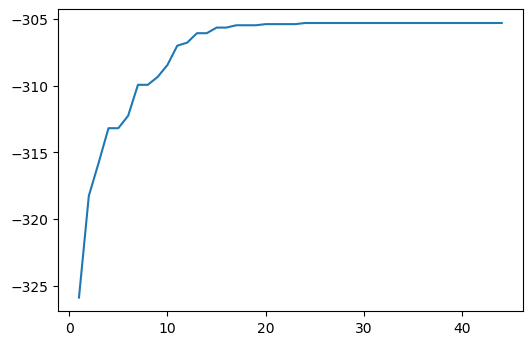

In [7]:
section = sections[180][:,:,0]

# path type planning
pt = time.time()
area_set = divide_image(section)
tf = partial(ga_tsp_path,section = section, area_set = area_set, initial_point = [0,0])
gaaa = GA_path(tf,50,[len(area_set),8],crossover_rate=0.9, mutation_rate = 0.1)
max_value, max_value_his, max_pop = gaaa.iteration(50)
print('time:',time.time()-pt)
fig,ax = plt.subplots()
ax.plot(np.arange(len(max_value_his))+1, max_value_his)
print('path length:',-max_value)


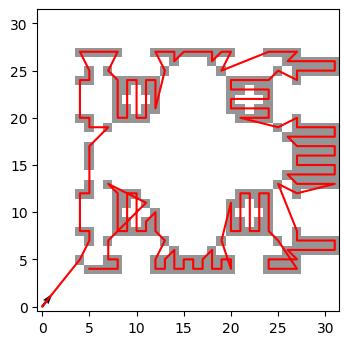

In [8]:
# plot
path_set = []
path_l_set = []
path_sf_set = []

for i in range(len(max_pop)):
    (path,L,sf) = zig_zag_from_points(area_set[i], flag = max_pop[i]+1)
    path_set.append(path)
    path_l_set.append(L)
    path_sf_set.append(sf)

(TL_tsp, path_order) = tsp_path(initial_point, path_sf_set)

T_path = [[],[]]
for i in path_order:
    if i == 0:
        T_path[0].extend([initial_point[0]])
        T_path[1].extend([initial_point[1]])
    else:
        T_path[0].extend(path_set[i-1][0])
        T_path[1].extend(path_set[i-1][1])
plot_image(section,[T_path],cv_map=[0,2])

max: 511.12310562561765 mean: 145.27573309199926


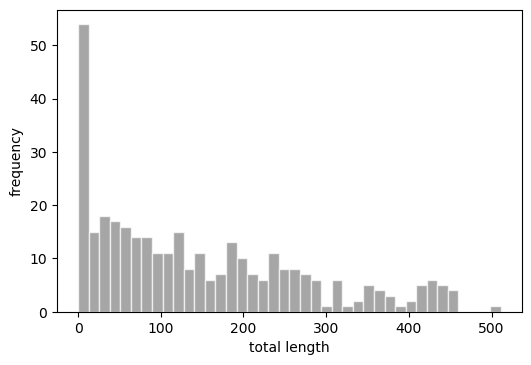

In [57]:
# lenth
# after tsp. note the initial point is the same for the same section
PL_set3 = []
for i in range(len(sections)):
    section = sections[i][:,:,0]
    area_set = divide_image(section)
    tf = partial(ga_tsp_path,section = section, area_set = area_set)
    gaaa = GA_path(tf,20,[len(path_set),8],mutation_rate = 0.1)
    max_value, max_value_his, max_pop = gaaa.iteration(50)
    PL_set3.append(-max_value)
    
print('max:',np.max(PL_set3),'mean:',np.mean(PL_set3))
plt.hist(PL_set3, bins=40, facecolor="grey", edgecolor="white", alpha=0.7)  
plt.xlabel('total length')
plt.ylabel('frequency')
plt.show()    



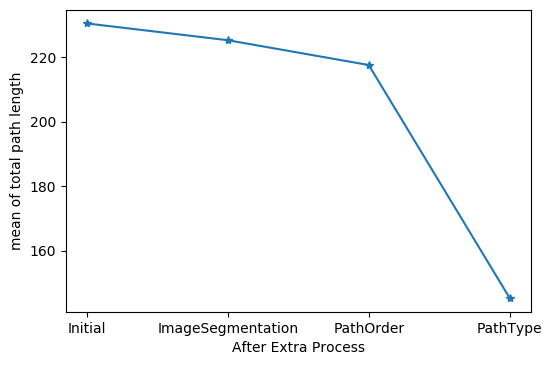

In [65]:
t = [1,2,3,4]
mean_set = [np.mean(PL_set0),np.mean(PL_set1),np.mean(PL_set2),np.mean(PL_set3)]
plt.plot(t,mean_set,'*-')
plt.xticks(t,['Initial','ImageSegmentation','PathOrder','PathType'])
plt.xlabel('After Extra Process')
plt.ylabel('mean of total path length')
plt.show()